# Customer to road network-assignment

In [28]:
%%html
<style>
table {float:left}
</style>

| Document info | |
| --- | --- | 
| Area of interest: | Singapore |
| Prepared by: | Waste Labs (wastelabs.co) |
| Prepared for: | Demonstration purposes |
| Contact: | info@wastelabs.co |

In [29]:
%load_ext kedro.ipython
%reload_kedro
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi=False

import pandas as pd

# Extra options
# Extra options
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import logging

logging.basicConfig(level=logging.INFO)

import importlib
import os
import sys

import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from geopandas.tools import sjoin
from GPSOdyssey import Kepler
from IPython.display import clear_output
from ipywidgets import fixed, interact, interact_manual, interactive
from shapely import wkt

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[06/30/23 18:18:48] INFO     Resolved project path as:                                              ]8;id=348788;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=969232;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#136\136]8;;\
                             /Users/ejwillemse/dev/projects/project-rdi-cape-town.                                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/30/23 18:18:48] INFO     Kedro project Project RDI Cape Town                                    ]8;id=352071;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=968842;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#105\105]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=798553;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=363811;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#106\106]8;;\
                             'pipelines'                                                                           

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from mcarptif.osmnx_network_extract.network_code_garp import (
    NetworkCode,
    create_gdf,
    create_latlon_gdf,
    customer_network_plot,
    return_crs,
)

## Get road network files

In [31]:
prep_network = catalog.load("road_network_simplified_24645_edges_xy_directed")
prep_network_plot = catalog.load("road_network_simplified_24645_edges_directed")

[06/30/23 18:18:49] INFO     Loading data from                                                  ]8;id=607726;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915397;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#345\345]8;;\
                             'road_network_simplified_24645_edges_xy_directed'                                     
                             (GeoJSONDataSet)...                                                                   

[06/30/23 18:18:53] INFO     Loading data from 'road_network_simplified_24645_edges_directed'   ]8;id=690799;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=228228;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#345\345]8;;\
                             (GeoJSONDataSet)...                                                                   

## Get lat-lon files

In [32]:
producer_file = catalog.load("syn_pop_lat_lon_ids_20220601")
producer_file = create_latlon_gdf(producer_file)

[06/30/23 18:18:58] INFO     Loading data from 'syn_pop_lat_lon_ids_20220601' (CSVDataSet)...   ]8;id=564233;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=939189;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#345\345]8;;\

<Axes: >

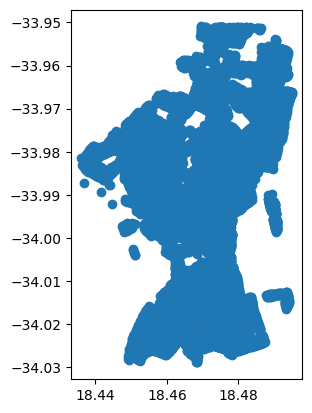

In [33]:
producer_file.plot()

In [34]:
%%time
df_producer_geo = producer_file.to_crs("EPSG:3414")

CPU times: user 17 ms, sys: 2.49 ms, total: 19.5 ms
Wall time: 19.2 ms


## Filter households in specific gap-zone

In [35]:
gap_zones = catalog.load("gap_zones").to_crs("EPSG:3414")
gap_zones_sample = gap_zones.loc[gap_zones["OBJECTID"].isin([24645])]
df_producer_geo_contained = gpd.tools.sjoin(df_producer_geo, gap_zones_sample, predicate="within")

[06/30/23 18:19:02] INFO     Loading data from 'gap_zones' (GeoJSONDataSet)...                  ]8;id=650492;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=398521;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#345\345]8;;\

In [36]:
df_producer_geo = df_producer_geo.loc[df_producer_geo["lat_lon_id"].isin(df_producer_geo_contained["lat_lon_id"])]
df_producer_geo.shape

(20681, 4)

### Customer locations

In [37]:
geocode_network = NetworkCode(prep_network, "SG", xy_converted=True)
geocode_network.set_arc_ids("arc_id", "geom_id_order")
geocode_network.convert_direct()

[06/30/23 18:19:03] INFO     Convert network to x-y                                        ]8;id=793160;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=329091;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#224\224]8;;\

                    INFO     Extracting nodes from network                                 ]8;id=393378;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=609732;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#240\240]8;;\

[06/30/23 18:19:04] INFO     Removing opposing network arcs (only need one).               ]8;id=828854;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=169965;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#255\255]8;;\

                    INFO     Arcs removed: 0.                                              ]8;id=543562;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=811435;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#260\260]8;;\

In [38]:
geocode_network.add_customers(df_producer_geo)

                    INFO     Adding 20681 customers.                                       ]8;id=928129;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=780597;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#208\208]8;;\

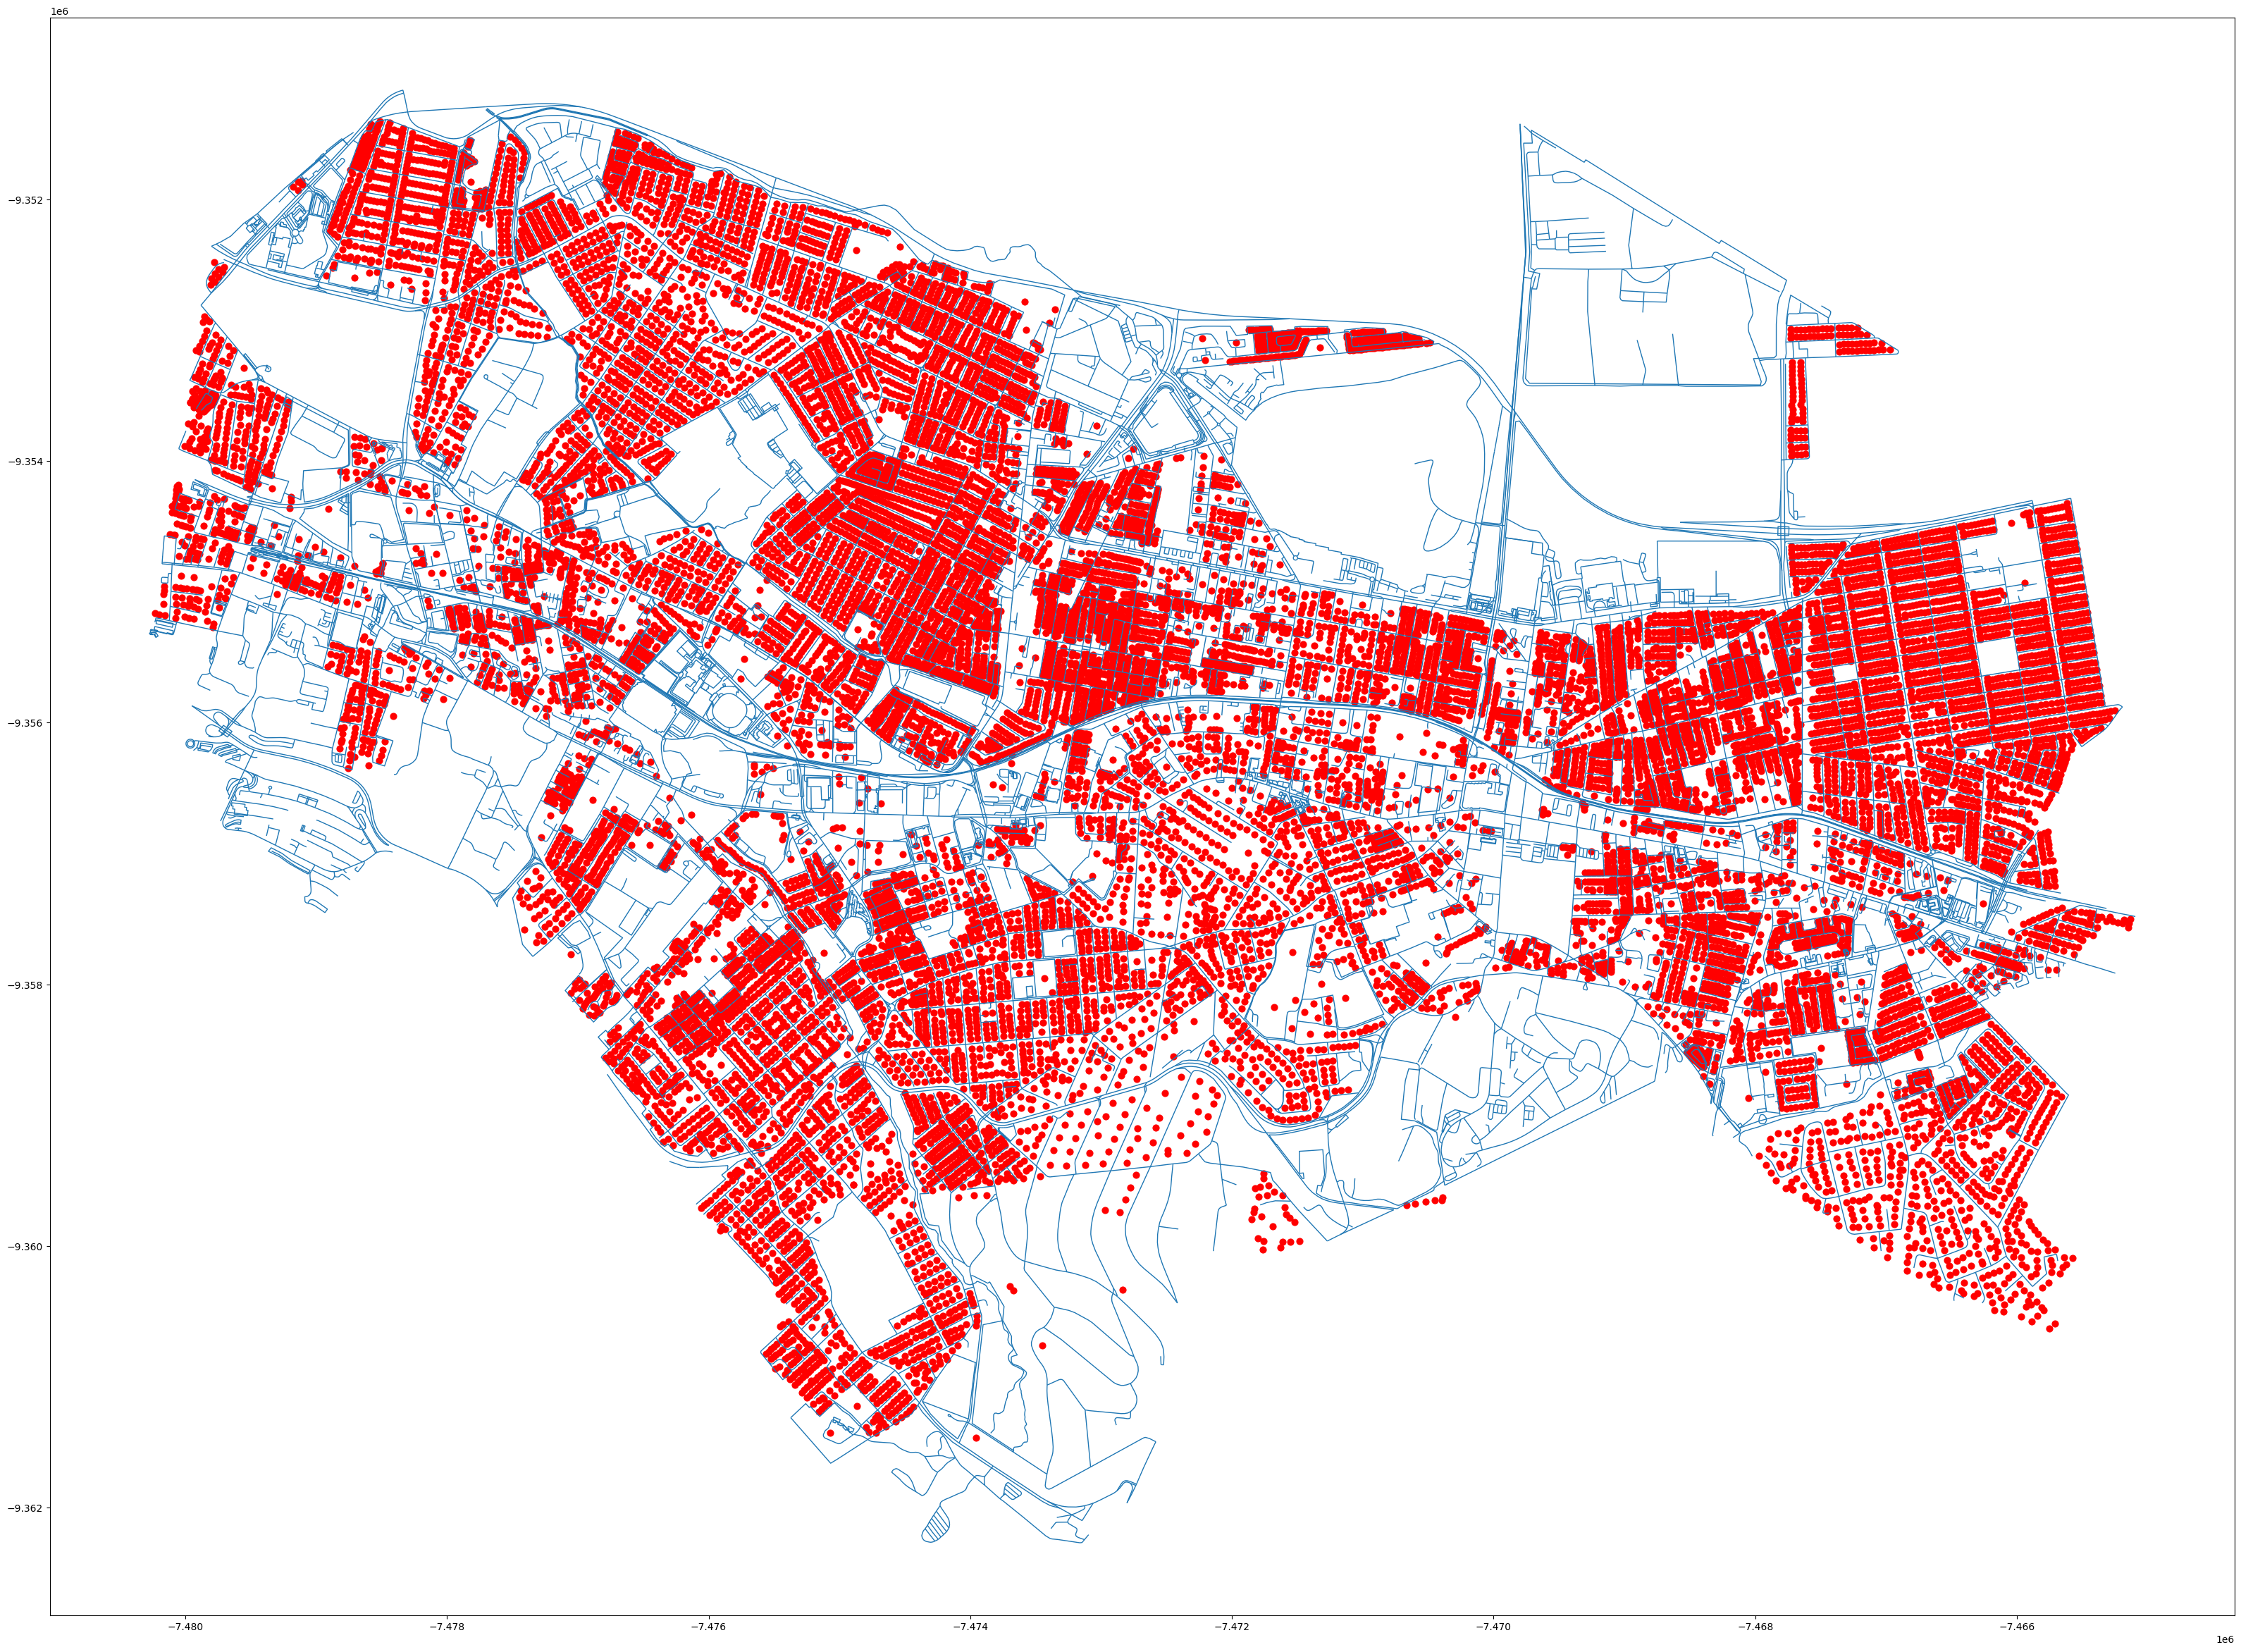

In [39]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=40, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1)

### Select road-types to use

In [40]:
prep_network["highway"] = prep_network["highway"].astype(str)
geocode_network.df_network["highway"] = geocode_network.df_network["highway"].astype(str)

In [41]:
road_select = list(prep_network["highway"].unique())
road_select.sort()
road_select.insert(0, "ALL")

multiple_prod_select = widgets.SelectMultiple(
    options=road_select,
    description="Road type:",
    value = ["living_street", 'residential', 'residential,living_street', 'residential,service', 'service,living_street', 'service,residential'],
    rows=20,
    disabled=False,
)


@interact
def filter_producers(descriptions=multiple_prod_select):
    global highway_select
    highway_select = descriptions
    if "ALL" not in highway_select:
        geocode_network.filter_network(
            filter_values=list(highway_select),
        )
    else:
        geocode_network.filter_network(
            filter_values=list(prep_network["highway"].unique())
        )
    geocode_network.df_network_filter = geocode_network.df_network_filter.set_index(
        ["u", "v", "key"]
    )
    print(highway_select)

interactive(children=(SelectMultiple(description='Road type:', index=(1, 7, 8, 9, 15, 16), options=('ALL', 'li…

[06/30/23 18:19:12] WARNING  /Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3 ]8;id=447098;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=368753;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py#109\109]8;;\
                             .10/site-packages/ipywidgets/widgets/widget_output.py:111:                            
                             DeprecationWarning: Kernel._parent_header is deprecated in ipykernel                  
                             6. Use .get_parent()                                                                  
                               if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel,                              
                             '_parent_header'):                                                                    
                                                                                                                   

                    WARNING  /Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3 ]8;id=775163;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=988809;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py#109\109]8;;\
                             .10/site-packages/ipywidgets/widgets/widget_output.py:112:                            
                             DeprecationWarning: Kernel._parent_header is deprecated in ipykernel                  
                             6. Use .get_parent()                                                                  
                               self.msg_id = ip.kernel._parent_header['header']['msg_id']                          
                                                                                                                   

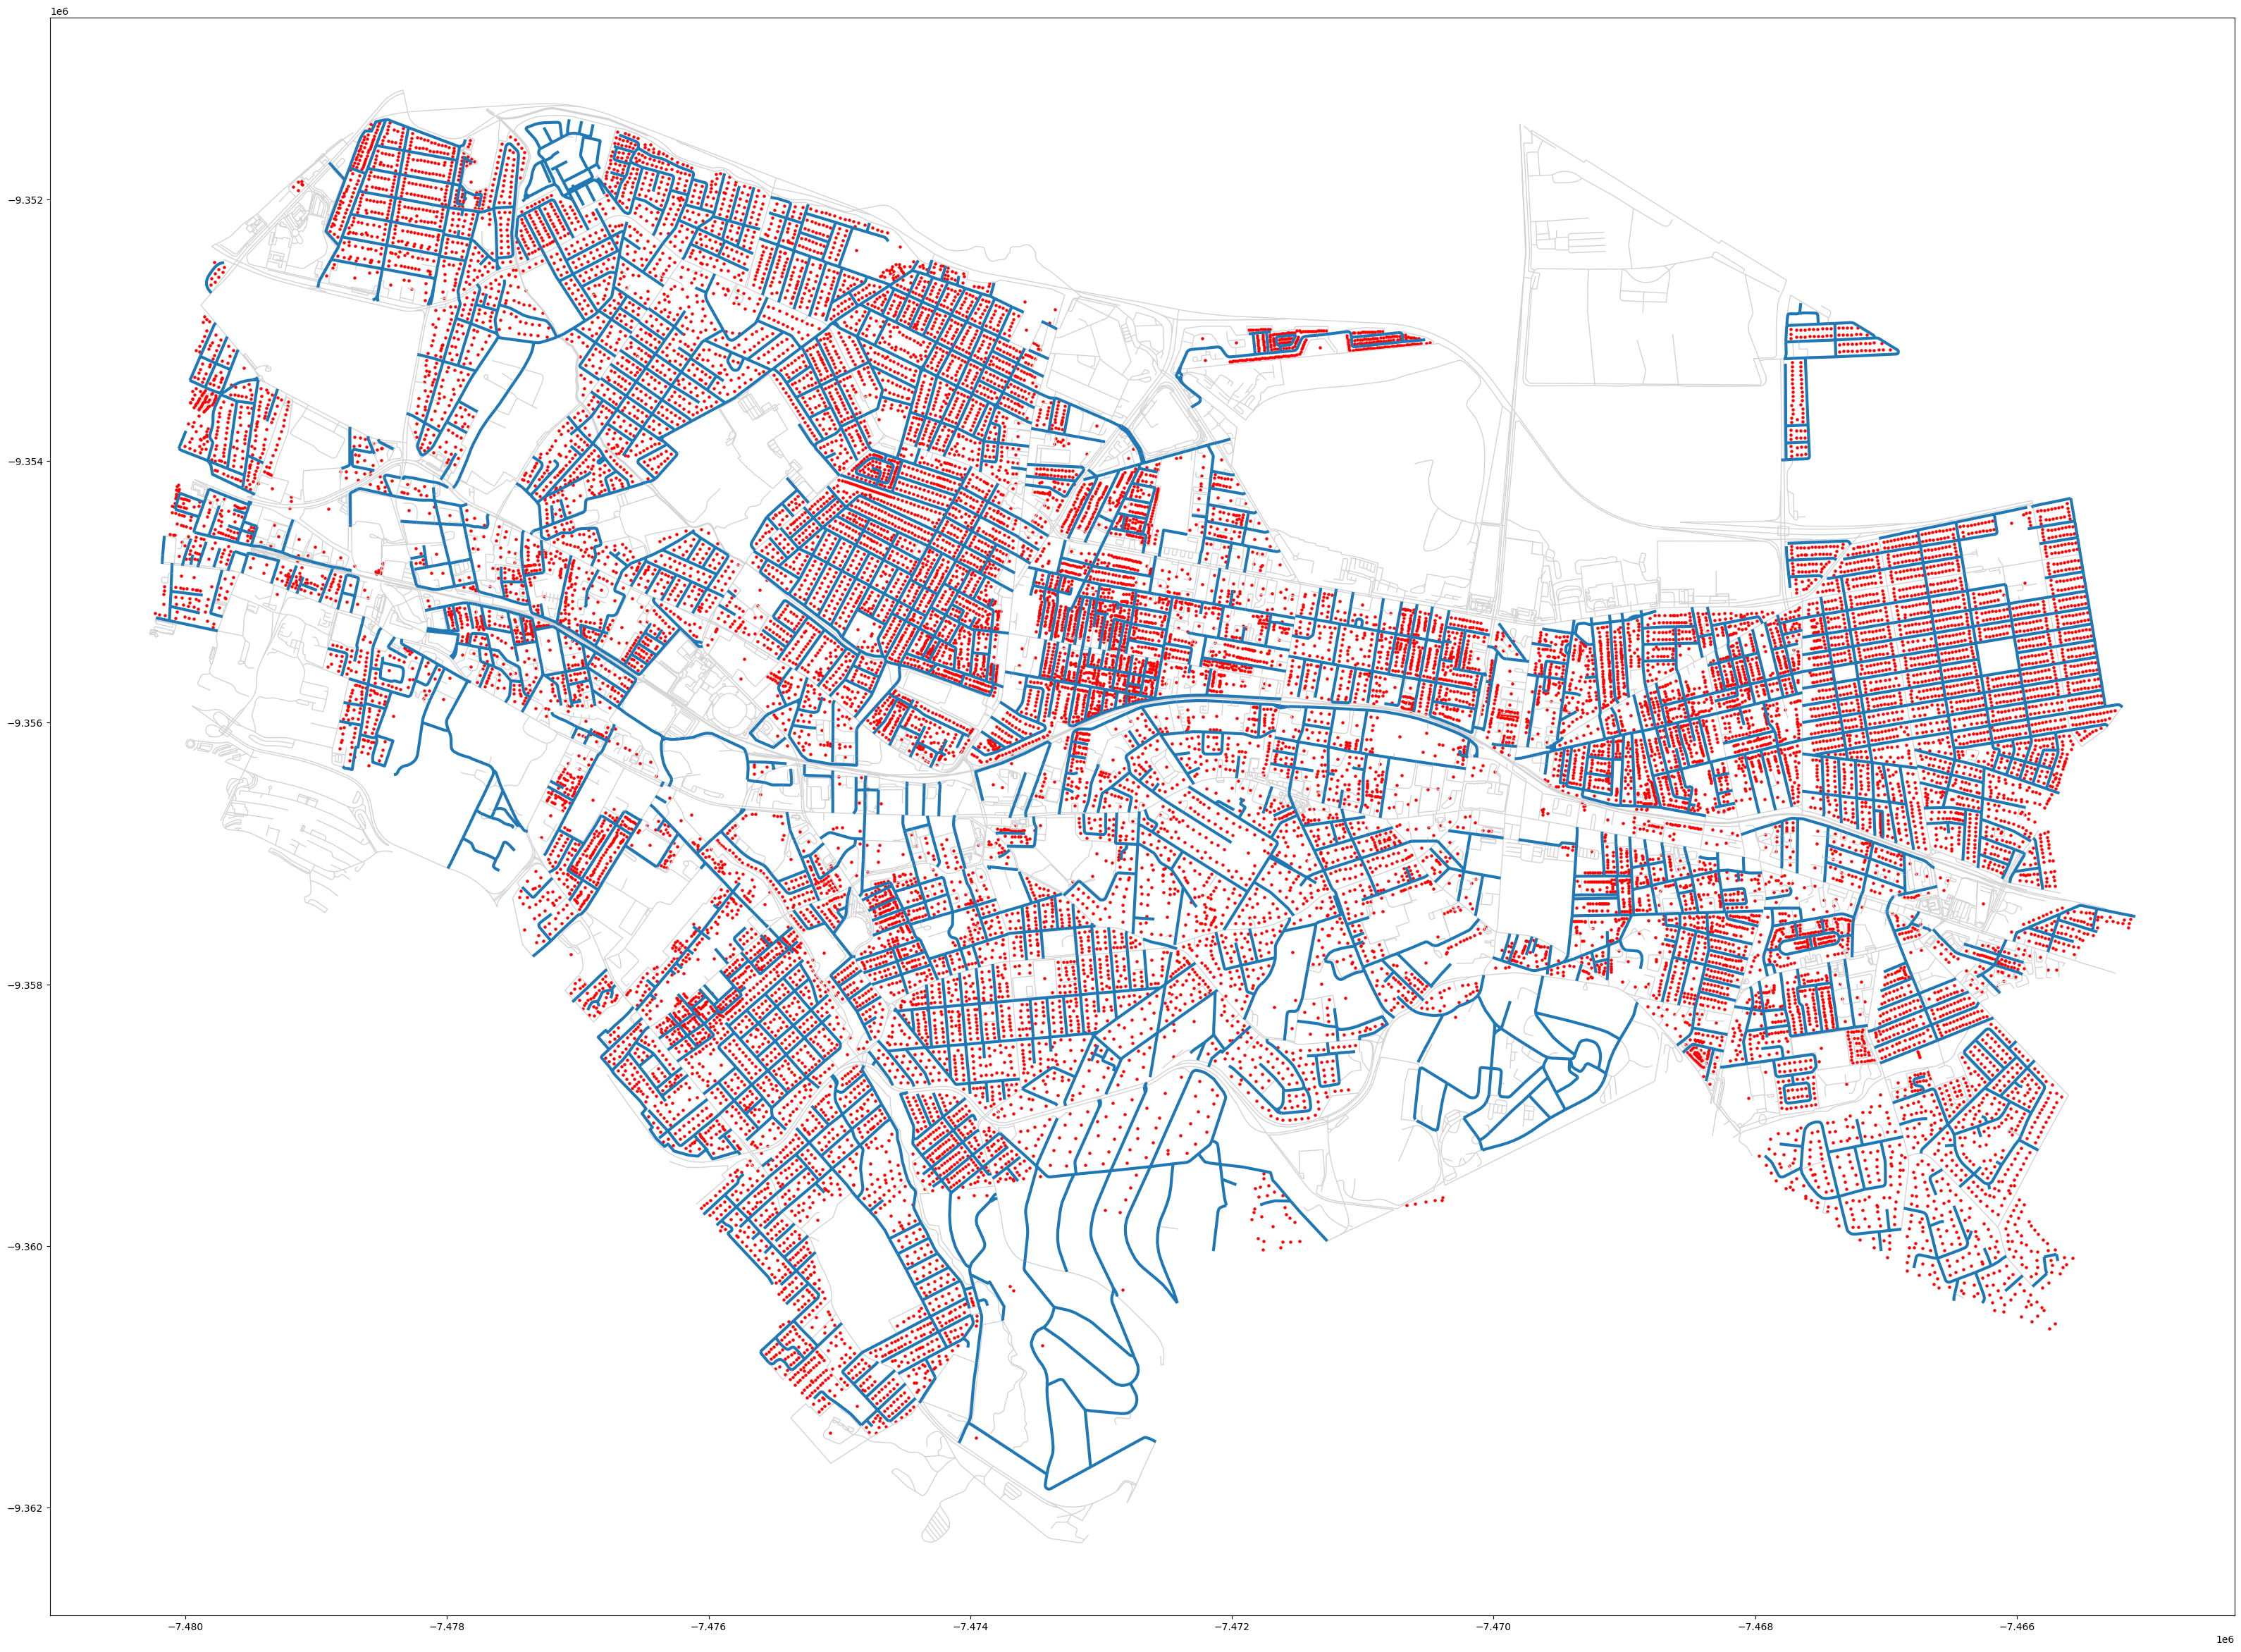

In [42]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=5, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1, color="lightgrey")
_ = geocode_network.df_network_filter.plot(ax=ax, linewidth=3)

In [43]:
fig.savefig('living_residential_streets_only.svg', format='svg', dpi=300, bbox_inches='tight')

In [44]:
%%time
geocode_network.find_nearest_collection_point()
geocode_network.merge_network()
geocode_network.convert_geometries_latlon()

[06/30/23 18:19:21] INFO     Find nearest arc                                              ]8;id=859580;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=954969;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#410\410]8;;\

                    INFO     Number of arcs 4177 number of points 20681                    ]8;id=440132;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=307299;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#411\411]8;;\

[06/30/23 18:19:35] INFO     Find closest assigned end point                               ]8;id=356908;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=419133;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#302\302]8;;\

                    INFO     Find closest point on assigned arc                            ]8;id=203622;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=962660;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#339\339]8;;\

[06/30/23 18:19:52] WARNING  /Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmn ]8;id=812424;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=594804;file:///Users/ejwillemse/.pyenv/versions/3.10.8/lib/python3.10/warnings.py#109\109]8;;\
                             x_network_extract/network_code_garp.py:351: FutureWarning: Not                        
                             prepending group keys to the result index of transform-like apply. In                 
                             the future, the group keys will be included in the index, regardless                  
                             of whether the applied function returns a like-indexed object.                        
                             To preserve the previous behavior, use                                                
                                                                                                                   
                                     >>> .groupby(..., group_keys=False)                                           
                                                                                                                   
                             To adopt the future behavior and silence this warning, use                            
                                                                                                                   
                                     >>> .groupby(..., group_keys=True)                                            
                               df["geometry_arc_snap_point"] =                                                     
                             df.groupby([arc_id]).apply(arc_snapping)                                              
                                                                                                                   

[06/30/23 18:19:53] INFO     Find best collection point                                    ]8;id=645010;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=51796;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#372\372]8;;\

                    INFO     Adding arc attributes.                                        ]8;id=637176;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=394498;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#452\452]8;;\

                    INFO     Convert geometries to lat-lon                                 ]8;id=865016;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py\network_code_garp.py]8;;\:]8;id=800011;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/src/mcarptif/osmnx_network_extract/network_code_garp.py#465\465]8;;\

CPU times: user 30.6 s, sys: 218 ms, total: 30.8 s
Wall time: 31.3 s


In [45]:
df_customer_fit = geocode_network.df_collection_points
plt_map = df_customer_fit[
    [
        "lon",
        "lat",
        "lon_collect",
        "lat_collect",
        "dist_collect",
        "arc_collect",
        "highway",
        "arc_id",
        "oneway",
    ]
].copy()
plt_map = plt_map.fillna("")
kep_map = Kepler(
    data={"customer_fit": plt_map.copy(), "road_network": prep_network_plot.copy()},
    height=1000,
    config_path="config/household_road_link_lat_lon_match_20220601.json",
)

                    INFO     Start preparation of render parameters...                                ]8;id=630710;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=387786;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#100\100]8;;\

                    INFO     Loading map config from file:                                            ]8;id=705208;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=392751;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#150\150]8;;\
                             config/household_road_link_lat_lon_match_20220601.json                                

                    INFO     Next columns are converted to string: ['arc_id', 'highway', 'oneway']     ]8;id=415363;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=977272;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#74\74]8;;\

                    INFO     Next columns are converted to string: ['access', 'width', 'ref',          ]8;id=632297;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=74924;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#74\74]8;;\
                             'landuse', 'junction', 'highway', 'service', 'name', 'geom_id_inv',                   
                             'arc_id', 'tunnel', 'osmid', 'bridge', 'oneway', 'lanes', 'maxspeed',                 
                             'geom_id', 'geom_id_order']                                                           

                    INFO     Start renderding KeplerGL map...                                         ]8;id=629475;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=10977;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#106\106]8;;\

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [46]:
m = kep_map.get_render()
m

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'n5f3efa', 'type': …

In [47]:
kep_map.save_config(path="config/household_road_link_lat_lon_match_20220601.json", overwrite_config=True)

[06/30/23 18:19:56] WARNING  File already exists and will be over-written.                             ]8;id=379813;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=661345;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#49\49]8;;\

In [48]:
kep_map.save_render(path="config/household_road_link_lat_lon_match_20220601.html", overwrite_html=True)

[06/30/23 18:19:57] WARNING  Such file exists and will be over-written.                               ]8;id=750276;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=864862;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#206\206]8;;\

                    INFO     Next columns are converted to string: ['arc_id', 'highway', 'oneway']     ]8;id=974517;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=248243;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#74\74]8;;\

                    INFO     Next columns are converted to string: ['access', 'width', 'ref',          ]8;id=437404;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py\Kepler.py]8;;\:]8;id=269069;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/GPSOdyssey/Kepler.py#74\74]8;;\
                             'landuse', 'junction', 'highway', 'service', 'name', 'geom_id_inv',                   
                             'arc_id', 'tunnel', 'osmid', 'bridge', 'oneway', 'lanes', 'maxspeed',                 
                             'geom_id', 'geom_id_order']                                                           

Map saved to config/household_road_link_lat_lon_match_20220601.html!


### Save scenario

In [49]:
%reload_kedro
catalog.save("lat_lon_key_network_match_20220601_residential_matches_only", geocode_network.df_collection_points)

[06/30/23 18:19:59] INFO     Resolved project path as:                                              ]8;id=125918;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=667514;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#136\136]8;;\
                             /Users/ejwillemse/dev/projects/project-rdi-cape-town.                                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/30/23 18:19:59] INFO     Kedro project Project RDI Cape Town                                    ]8;id=846506;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=37087;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#105\105]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=778257;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=304409;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#106\106]8;;\
                             'pipelines'                                                                           

                    INFO     Saving data to                                                     ]8;id=327160;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=661890;file:///Users/ejwillemse/dev/projects/project-rdi-cape-town/.venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#384\384]8;;\
                             'lat_lon_key_network_match_20220601_residential_matches_only'                         
                             (CSVDataSet)...                                                                       